In [1]:
import sys
sys.path.append('../')
import random
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from preprocess.datasets import PTBDataset
from preprocess.preprocess import load_dataset, compute_label_agg, select_data, sample_class

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (
    use_cuda and torch.cuda.is_available()) else "cpu")

torch.manual_seed(0)

CUDA is available: True


# Defining Generator


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_size=12, hidden_size=64,
                            bidirectional=True, batch_first=True)
        self.main1 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=128,
                      kernel_size=16, padding='same'),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=128, out_channels=64,
                      kernel_size=16, padding='same'),
            nn.LeakyReLU(),
        )
        self.main2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=32,
                      kernel_size=16, padding='same'),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=32, out_channels=16,
                      kernel_size=16, padding='same'),
            nn.LeakyReLU(),
        )
        self.final = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=1,
                      kernel_size=16, padding='same'),
            nn.Tanh()
        )

    def forward(self, noise):
        x, _ = self.lstm(noise)
        x = x.permute(0, 2, 1)

        x = self.main1(x)
        x = nn.functional.interpolate(x, scale_factor=2)
        x = self.main2(x)
        x = nn.functional.interpolate(x, scale_factor=2)
        x = self.final(x)
        x = x.permute(0, 2, 1)

        return x

# Defining Critic


In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.main1 = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=32,
                      kernel_size=16, padding='same'),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=32, out_channels=64,
                      kernel_size=16, padding='same'),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=64, out_channels=128,
                      kernel_size=16, padding='same'),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=128, out_channels=256,
                      kernel_size=16, padding='same'),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=25600, out_features=1),
        )

    def forward(self, x):

        x = x.double()
        x = x.permute(0, 2, 1)
        x = self.main1(x)

        return x

In [5]:
def train(loader, generator, discriminator, gen_optim, disc_optim, criterion, epochs, noise_dim):
    gen_losses = []
    disc_losses = []
    generator.train()
    discriminator.train()

    for _ in tqdm(range(epochs)):

        for input, _, _ in loader:
            ################################
            # Training discriminator
            ################################
            input = input[:, :400, :1]
            disc_optim.zero_grad()
            # All real
            real_labels = torch.ones(input.size(
                0), dtype=torch.double, device=device)
            # Forward pass real batch through discriminator
            output = discriminator(input.to(device)).view(-1).double()
            # Compute loss
            err_disc_real = criterion(output, real_labels)
            err_disc_real.backward()

            # All fake
            noise = torch.randn(noise_dim, device=device)
            # Generate fake batch with generator
            fake = generator(noise)
            fake_labels = torch.zeros(
                fake.size(0), dtype=torch.double, device=device)
            # Classify fake batch with discriminator
            output = discriminator(fake.detach()).view(-1).double()
            # Compute loss
            err_disc_fake = criterion(output, fake_labels)
            err_disc_fake.backward()
            # Compute total loss for discriminator
            err_disc = err_disc_real + err_disc_fake
            disc_losses.append(err_disc)

            disc_optim.step()
            ################################
            # Training generator
            ################################
            gen_optim.zero_grad()

            desired_labels = torch.ones(
                fake.size(0), dtype=torch.double, device=device)
            # Classify once again
            output = discriminator(fake).view(-1).double()
            err_gen = criterion(output, desired_labels)
            gen_losses.append(err_gen)

            err_gen.backward()
            gen_optim.step()

    return gen_losses, disc_losses, generator, discriminator

In [6]:
BATCH_SIZE = 64

noise_dim = [BATCH_SIZE, 100, 12]

In [7]:
LOAD_DATASET = True
DATA_PATH = './trainloader.pt'


In [8]:
if LOAD_DATASET:
    train_loader = torch.load(DATA_PATH)
else:
    path = '../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

    data, raw_labels = load_dataset(path)

    labels = compute_label_agg(raw_labels, path)

    data, labels, Y = select_data(data, labels)

    data, labels, Y = sample_class(data, labels, Y, 'HYP')

    ds = PTBDataset(data, labels, Y, embed_path='../data/embeddings/')

    train_loader = DataLoader(dataset=ds, batch_size=BATCH_SIZE)

    torch.save(train_loader, DATA_PATH)

In [9]:
for batch in train_loader:
    inputs, outputs, text = batch
    print(inputs.shape)
    break


torch.Size([64, 1000, 12])


torch.Size([1, 400, 1])


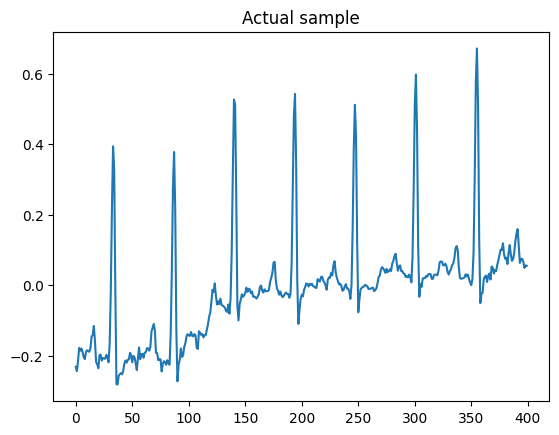

In [10]:
idx = random.randint(0, BATCH_SIZE)
sample = inputs[idx:idx+1, :400, :1]
print(sample.shape)
sq = sample.flatten()
plt.plot(sq)
plt.title("Actual sample")
plt.show()


In [11]:
discriminator = Discriminator(1).double()

pred = discriminator(sample)
print(pred)

tensor([[0.0090]], dtype=torch.float64, grad_fn=<AddmmBackward0>)


d:\Python\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:896.)
  return F.conv1d(input, weight, bias, self.stride,


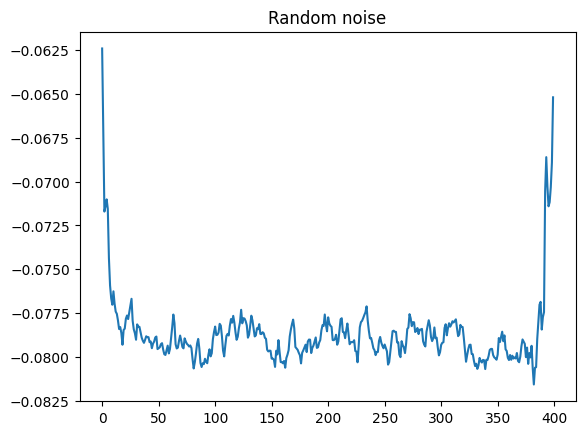

In [12]:
noise = torch.randn([1, 100, 12])
generator = Generator()
generated = generator(noise).view(-1)
plt.plot(generated.detach().numpy())
plt.title("Random noise")
plt.show()


In [13]:
EPOCH = 5
generator = Generator().to(device)
discriminator = Discriminator(1).double().to(device)

gen_optim = optim.Adam(generator.parameters(), 0.0002)
disc_optim = optim.Adam(discriminator.parameters(), 0.0002)

criterion = nn.BCEWithLogitsLoss()

gen_losses, disc_losses, generator, discriminator = train(
    train_loader, generator, discriminator, gen_optim, disc_optim, criterion, EPOCH, noise_dim)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

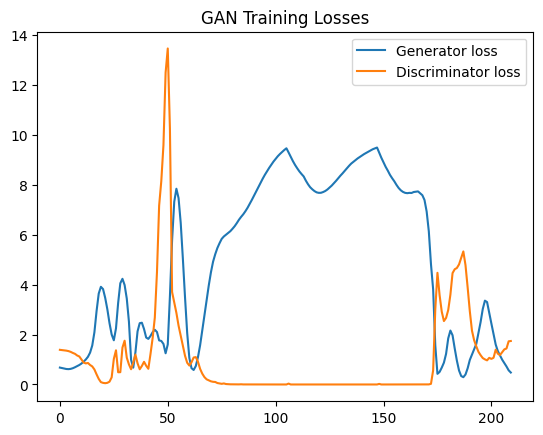

In [ ]:
plt.plot([x.cpu().detach().numpy()
         for x in gen_losses], label="Generator loss")
plt.plot([x.cpu().detach().numpy()
         for x in disc_losses], label='Discriminator loss')
plt.legend()
plt.title("GAN Training Losses")
plt.show()

0.5787423069553084


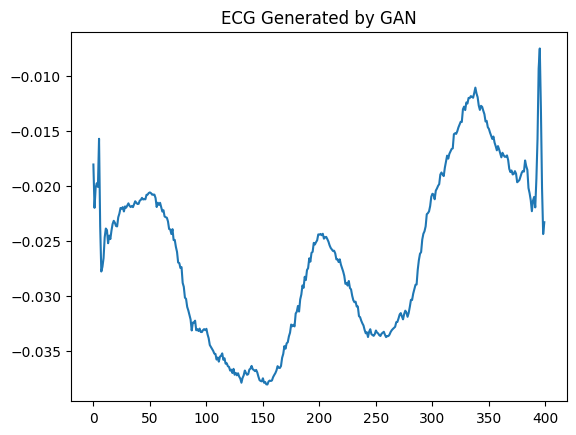

In [ ]:
DEMO_SAMPLES = 10
while DEMO_SAMPLES > 0:
    noise = torch.randn([1, 100, 12]).to(device)
    generated = generator(noise)
    print(discriminator(generated).item())
    # break
    if discriminator(generated).item() > 0.5:
        g = generated.permute(0, 2, 1).flatten()

        plt.plot(g.cpu().detach().numpy())
        plt.title("ECG Generated by GAN")
        plt.show()
        DEMO_SAMPLES -= 1
    break
